## Krusell Smith Model

Here, I solve an example Krusell-Smith model using my toolkit. The model is standard with code in [krusell_smith.py](models/krusell_smith.py).

#### Config

In [1]:
from models.krusell_smith import KrusellSmith  # model code
import matplotlib.pyplot as plt  # plot things
# from toolkit.irfs import *  # impulse responses
import numpy as np  # matrix/vector things

#### Steady State
Using the EGM, solve for the steady state of the model.

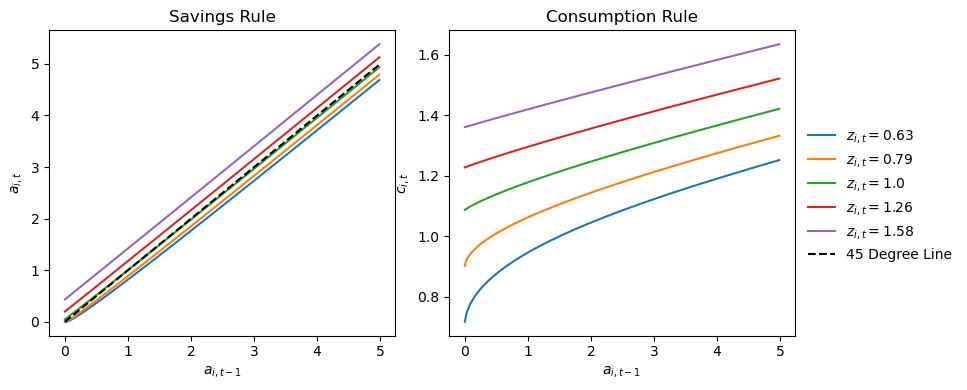

In [2]:
## intialize model
mod_pars = {
        'beta': 0.95, 'gamma': 2., 'delta': 0.05,  # household parameters
        'N_z': 5, 'rho_z': 0.9, 'sigma_z': 0.1,  # household state transitions
        'alpha': 0.3,  # govt parameters
        'A': 1.,  # shock steady state
        'N_a': 501, 'a_min': 0, 'a_max': 500,  # grid states
    }
ks = KrusellSmith(**mod_pars)

## solve steady state
free = ['K']
endog = ['Y', 'W', 'R']
V_a0 = (ks.a_grid[:, None] * (1 / ks.beta - 1) + ks.z_grid)**(-ks.gamma)
X0 = np.array([5.])
ks.solve_ss(free, endog, V_a0, X0)
assert np.isclose(ks.curlC + ks.K * ks.delta - ks.Y, 0)  # walras

## plot policy functions
# setup plot
fig, axs = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(10)
max_plotted_a = 5  # all the interesting things happen at the start, only plot a < this
n_gps = (ks.a_grid <= max_plotted_a).sum()  # number of gridpoints we plot
axs[0].set_title('Savings Rule')
axs[0].set_xlabel('$a_{i, t-1}$')
axs[0].set_ylabel('$a_{i, t}$')
axs[1].set_title('Consumption Rule')
axs[1].set_xlabel('$a_{i, t-1}$')
axs[1].set_ylabel('$c_{i, t}$')

# savings rule
axs[0].plot(ks.a_grid[:n_gps], ks.a[:n_gps], label=['$z_{i, t}='+str(round(z, 2))+'$' for z in ks.z_grid])
axs[0].plot([0, ks.a_grid[n_gps - 1]], [0, ks.a_grid[n_gps - 1]], 'k--', label='45 Degree Line')

# consumoption rule
axs[1].plot(ks.a_grid[:n_gps], ks.c[:n_gps])

# final things
fig.tight_layout()
fig.subplots_adjust(right=8/10)
fig.legend(loc='center left', bbox_to_anchor=(8/10, 0.5), frameon=False)

#### Shocks
We can also shock the model and look at IRFs.

In [ ]:
# solve for perturbation matrix
T = 300
G, dxs = ks.solve_G(T, ha=True)  # ha=True is used later to look at policy function responses

# config
vars = ['K', 'Y', 'W', 'R', 'curlK', 'curlC']  # variables we're interested in
labels = {'K': '$K_t$', 'Y': '$Y_t$', 'W': '$W_t$', 'R': '$R_t$', 'curlK': r'$\mathcal{K}$', 'curlC': r'$\mathcal{C}$'}
n = 100  # number of periods we plot

# get irfs
irfs = single_shock_irfs(G['A'], 0.9, T)[0]

# plot config
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(12)
fig.set_figheight(6)
fig.suptitle('1% TFP Shock')

# plot irfs
for i in range(6):
    # variables for i
    v = vars[i]
    ax = axs.take(i)

    # plot it
    ax.set_title(labels[v])
    ax.set_xlabel('$t$')
    ax.set_ylabel('% Dev. From SS')
    ax.plot(irfs[v][:n] / ks.__getattribute__(v))

# final things
fig.tight_layout()

#### Decomposition
We can decompose the shock into the different transmission channels.

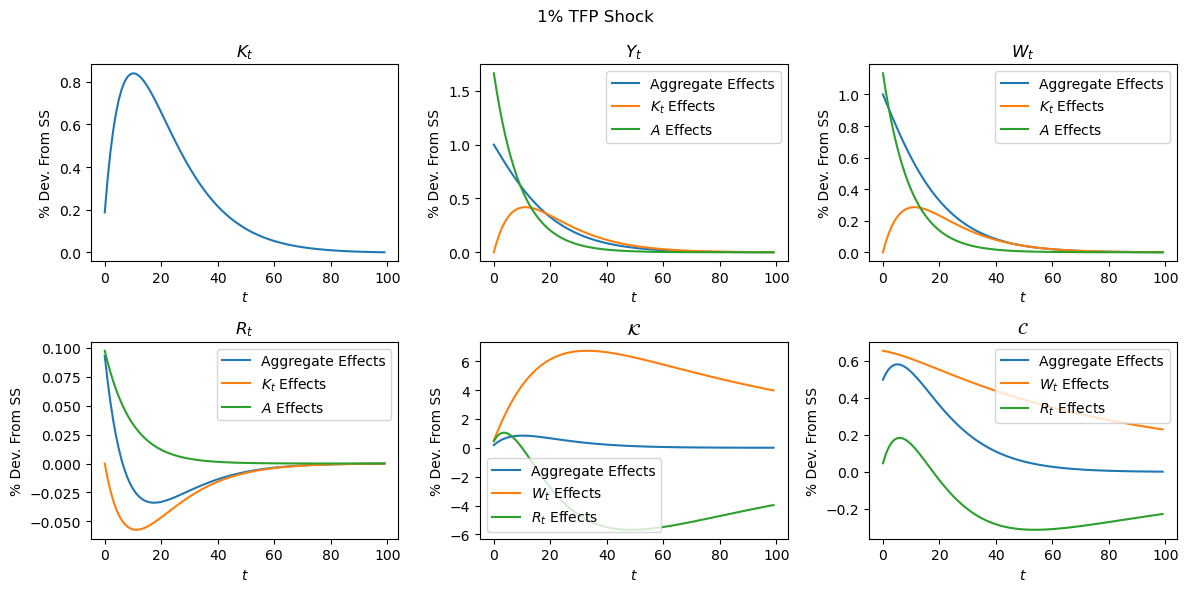

In [4]:
#$ uses the G solved for in the last block
# setup
vars = ['K', 'Y', 'W', 'R', 'curlK', 'curlC']  # variables we're interested in
labels = {'K': '$K_t$', 'Y': '$Y_t$', 'W': '$W_t$', 'R': '$R_t$', 'curlK': r'$\mathcal{K}$', 'curlC': r'$\mathcal{C}$', 'A': '$A$'}
n = 100  # number of periods we plot

# get irfs
irfs, exog_irf = single_shock_irfs(G['A'], 0.9, T)
decomp = decompose_single_shock_irfs(G['A'], ks.int_block_jacs, exog_irf, 'A')

# plot config
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(12)
fig.set_figheight(6)
fig.suptitle('1% TFP Shock')

# plot irfs
for i in range(6):
    # variables for i
    v = vars[i]
    ax = axs.take(i)

    # plot irf
    ax.set_title(labels[v])
    ax.set_xlabel('$t$')
    ax.set_ylabel('% Dev. From SS')
    ax.plot(irfs[v][:n] / ks.__getattribute__(v), label='Aggregate Effects')

    # decomposition
    if v not in decomp.keys():
        continue
    for v2, irf in decomp[v].items():
        ax.plot(irf[:n], label=f'{labels[v2]} Effects')

    # legend
    ax.legend()

# final things
fig.tight_layout()

#### Policy Functions
We can also look at how policy functions shift post-shock.

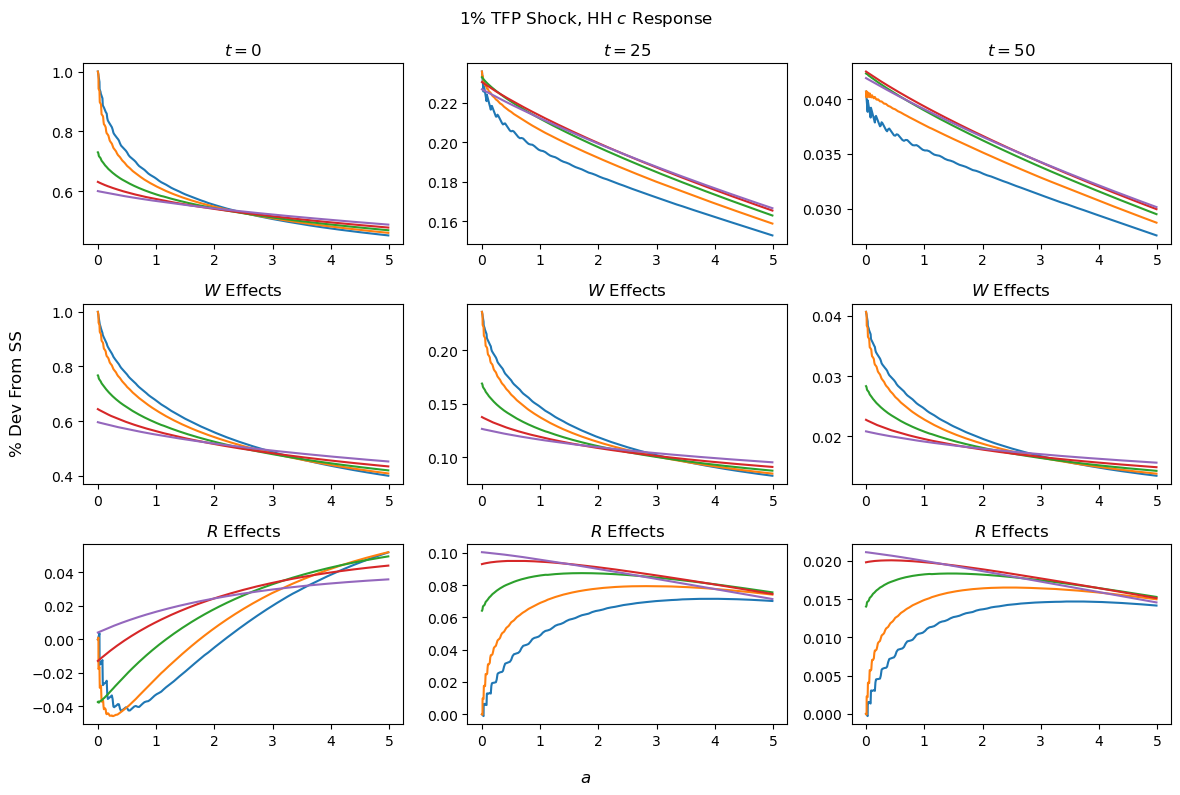

In [5]:
## uses G from above
# setup
var = 'c'
labels = {'K': '$K_t$', 'Y': '$Y_t$', 'W': '$W_t$', 'R': '$R_t$', 'curlK': r'$\mathcal{K}$', 'curlC': r'$\mathcal{C}$', 'A': '$A$'}
ts = [0, 25, 50]
n = (ks.a_grid < 5).sum()  # number of gridpoints we plot

# get irfs
_, exog_irf = single_shock_irfs(G['A'], 0.9, T)
pol_irf = policy_irf(dxs[var], G['A'], exog_irf, 'A')
pol_decomp = decompose_policy_irf(dxs[var], G['A'], exog_irf, 'A')

# plot config
fig, axs = plt.subplots(3, 3)
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle(f'1% TFP Shock, HH ${var}$ Response')
fig.supxlabel('$a$')
fig.supylabel('% Dev From SS')

# plot irfs
for i in range(3):
    # variables for i
    t = ts[i]
    # ax = axs.take(i)

    # plot irf
    axs[0, i].set_title(f'$t = {t}$')
    axs[0, i].plot(ks.a_grid[:n], pol_irf[t, :n] / ks.__getattribute__(var)[:n])

    # decomposition
    axs[1, i].set_title('$W$ Effects')
    axs[1, i].plot(ks.a_grid[:n], pol_decomp['W'][t, :n] / ks.__getattribute__(var)[:n])
    axs[2, i].set_title('$R$ Effects')
    axs[2, i].plot(ks.a_grid[:n], pol_decomp['R'][t, :n] / ks.__getattribute__(var)[:n])

# final things
fig.tight_layout()

In [3]:
from toolkit.estimation import *

In [11]:
estG = estimation_G(G, ['Y', 'K'])

# get the impulse response functions and standard deviations (used in covarience calcualtion)
irfs = all_shock_irfs(estG, np.ones(1))

# get covarience
cov = covariences(irfs, np.ones(1))[:None]
cov.shape

(300, 2, 2)